__This notebook show the model evaludation results of the models using Morgan2 fingerprint__
- Use the my-rdkit-env environment

In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Import data

In [3]:
train_test_path = "/home/mylab-pharma/Code/tuele/XO/data/train_test_data/XO_train_test_data.xlsx"
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
test_dataset = pd.read_excel(train_test_path, sheet_name='test_dataset')
validation_dataset = pd.read_excel(train_test_path, sheet_name='validation_dataset')

In [4]:
print(len(train_dataset), len(test_dataset), len(validation_dataset))

337 73 73


In [5]:
train_dataset.head()

,CID,SMILES,IC50(nM),Type,substructure
0,145967694,CC1=CC2=C(C=C1)N=C(O2)/C(=N/O)/CC3=CC=CC=C3,17500.0,active,7
1,76329670,CC1(C=CC2=CC(=C(C=C2O1)O)C(=O)/C=C/C3=CC(=C(C=...,1800.0,inactive,16
2,5320686,C1=CC(=CC=C1/C=C/C(=O)OC[C@@H]2[C@H]([C@@H]([C...,100000.0,active,6
3,155903284,C1=CC(=CC=C1C2=NC=NN2)NC(=O)C3C(NC(=O)NC3=O)O,1400.0,inactive,1
4,137648214,CCCCC1=NN2C(=N1)C3=C(NC2=O)NN=C3,529.0,inactive,9


# 2. Model training with Morgan2 fingerprint

## Morgan2 fingerprint encoding

In [6]:
#MACCS
from tqdm import tqdm

def maccs_fpts(data):
    Maccs_fpts = []
    count = 0
    with tqdm(total=len(data), desc='Progress') as pbar:
        for i in data:
            try:
                mol = Chem.MolFromSmiles(i)
            except:
                print("An exception occurred with " + str(count))
                continue
            fpts = MACCSkeys.GenMACCSKeys(mol)
            mfpts = np.array(fpts)
            Maccs_fpts.append(mfpts)
            count += 1
            pbar.update(1)  # Update the progress bar
    return np.array(Maccs_fpts)

#maccs
def morgan_fpts(data):
    Morgan_fpts = []
    count = 0
    with tqdm(total=len(data), desc='Progress') as pbar:
        for i in data:
            try:
                mol = Chem.MolFromSmiles(i)
            except:
                print("An exception occurred with " + str(count))
                continue
            fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
            mfpts = np.array(fpts)
            Morgan_fpts.append(mfpts)
            count += 1
            pbar.update(1)  # Update the progress bar
    return np.array(Morgan_fpts)

In [7]:
#X data
X_Train = morgan_fpts(train_dataset['SMILES'])
X_Test = morgan_fpts(test_dataset['SMILES'])
X_Validation = morgan_fpts(validation_dataset['SMILES'])

Progress:   0%|          | 0/337 [00:00<?, ?it/s][00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:49] DEPRECATION WARNING: please use MorganGenerator
[00:28:

In [8]:
#y data
y_Train = np.array(train_dataset['Type'])
y_Test = np.array(test_dataset['Type'])
y_Validation = np.array(validation_dataset['Type'])

#Original data
print("Original data:")
print(y_Train[0:5])
print(y_Test[0:5])
print(y_Validation[0:5])

#One-hot encoder
import sklearn.preprocessing as preprocessing
label_encoder = preprocessing.LabelEncoder()
y_Train = label_encoder.fit_transform(y_Train)
y_Test = label_encoder.fit_transform(y_Test)
y_Validation = label_encoder.fit_transform(y_Validation)
print("Encoded data:")
print(y_Train[0:5])
print(y_Test[0:5])
print(y_Validation[0:5])

Original data:
['active' 'inactive' 'active' 'inactive' 'inactive']
['inactive' 'inactive' 'active' 'active' 'inactive']
['active' 'inactive' 'active' 'active' 'active']
Encoded data:
[0 1 0 1 1]
[1 1 0 0 1]
[0 1 0 0 0]


## Model training

__Random Forest Classifier__

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf_morgan2 = RandomForestClassifier(n_estimators=26, criterion='entropy', random_state=0)
rf_morgan2.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', n_estimators=26, random_state=0)

__K Nearest Neighbor__

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn_morgan2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_morgan2.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [11]:
from sklearn.svm import SVC
svm_morgan2 = SVC(kernel='rbf', random_state=0, probability=True)
svm_morgan2.fit(X_Train, y_Train)

SVC(probability=True, random_state=0)

__XGBoost__

In [12]:
from xgboost import XGBClassifier
# bst_morgan2 = XGBClassifier(objective='binary:logistic', tree_method="hist")
bst_morgan2 = XGBClassifier(objective='binary:logistic', tree_method="hist", max_depth=2)
bst_morgan2.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Model evaluation

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    precision = tp / (tp +fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return ac, precision, recall, mcc, f1

def me_result(cm, model_name):
    cm_string = "Confusion matrix of " + model_name
    print(cm_string)
    print(cm)
    ac, se, sp, mcc, f1 = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [['Model', 'AC', 'SE', 'SP', 'MCC', 'F1'], [model_name, ac, se, sp, mcc, f1]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

### 1. Calculate all the evaluation metrics on test and validation dataset

In [14]:
X_Total = np.concatenate((X_Train, X_Validation), axis=0)
y_Total = np.concatenate((y_Train, y_Validation), axis=0)

In [15]:
len(X_Test)

73

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

cols = ['Model', 'Fingerprint', 
        '10-fold cross validation AC', 'Test-set Accuracy', 'Test-set Precision', 'Test-set Recall', 'Test-set MCC', 'Test-set F1', 'Test-set AUC', 
        'Training error', 'Test error', 'Validation error',
        'Validation-set Accuracy', 'Validation-set Precision', 'Validation-set Recall', 'Validation-set MCC', 'Validation-set F1', 'Validation-set AUC']

model_result = pd.DataFrame(columns=cols)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

for model_name in ['KNN', 'RF', 'SVM', 'XgBoost']:
    cv_scores = None
    y_pred_test = None
    y_pred_train = None
    y_pred_validation = None
    model = None
    
    if model_name == 'KNN':
        model = knn_morgan2
    elif model_name == 'RF':
        model = rf_morgan2
    elif model_name == 'SVM':
        model = svm_morgan2
    elif model_name == 'XgBoost':
        model = bst_morgan2
    else:
        print("Error")
    
    
    #Cross validation
    cv_scores = cross_val_score(model, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
    
    #Test set
    y_pred_test = model.predict(X_Test)
    y_proba_test = model.predict_proba(X_Test)[:, 1]
    auc_score_test = roc_auc_score(y_Test, y_proba_test)
    cm_test = confusion_matrix(y_Test, y_pred_test)
    test_ac, test_precision, test_recall, test_mcc, test_f1 = model_evaluation_calculation(cm_test)
    test_error = 1 - test_ac
    
    #validation set
    y_pred_validation = model.predict(X_Validation)
    y_proba_validation = model.predict_proba(X_Validation)[:, 1]
    auc_score_validation = roc_auc_score(y_Validation, y_proba_validation)
    cm_validation = confusion_matrix(y_Validation, y_pred_validation)
    validation_ac, validation_precision, validation_recall, validation_mcc, validation_f1 = model_evaluation_calculation(cm_validation)
    validation_error = 1 - validation_ac
    
    #train set
    y_pred_train = model.predict(X_Train)
    y_proba_train = model.predict_proba(X_Train)[:, 1]
    auc_score_train = roc_auc_score(y_Train, y_proba_train)
    cm_train = confusion_matrix(y_Train, y_pred_train)
    train_ac, _, _, _, _ = model_evaluation_calculation(cm_train)
    train_error = 1 - train_ac
    
    row_result = pd.DataFrame([[model_name, "Morgan2", 
                                np.mean(cv_scores)*100, test_ac*100, test_precision*100, test_recall*100, test_mcc*100, test_f1*100, auc_score_test*100, 
                                train_error*100, test_error*100, validation_error*100,
                                validation_ac*100, validation_precision*100, validation_recall*100, validation_mcc*100, validation_f1*100, auc_score_validation*100]], 
                                columns=cols)
    
    model_result = pd.concat([model_result, row_result], ignore_index=True)

/tmp/ipykernel_429305/3244982891.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_result = pd.concat([model_result, row_result], ignore_index=True)


In [17]:
model_result.head()

,Model,Fingerprint,10-fold cross validation AC,Test-set Accuracy,Test-set Precision,Test-set Recall,Test-set MCC,Test-set F1,Test-set AUC,Training error,Test error,Validation error,Validation-set Accuracy,Validation-set Precision,Validation-set Recall,Validation-set MCC,Validation-set F1,Validation-set AUC
0,KNN,Morgan2,84.390244,79.452055,72.5,87.878788,60.378788,79.452055,89.280303,9.495549,20.547945,12.328767,87.671233,82.5,94.285714,76.151486,88.000000,95.075758
1,RF,Morgan2,87.804878,89.041096,87.5,92.105263,78.113764,89.743590,94.015152,0.296736,10.958904,10.958904,89.041096,82.5,97.058824,79.289697,89.189189,94.621212
2,SVM,Morgan2,86.341463,89.041096,90.0,90.000000,77.878788,90.000000,93.333333,5.637982,10.958904,8.219178,91.780822,90.0,94.736842,83.623237,92.307692,95.303030
3,XgBoost,Morgan2,86.585366,87.671233,85.0,91.891892,75.566384,88.311688,93.106061,2.967359,12.328767,19.178082,80.821918,75.0,88.235294,62.736367,81.081081,91.704545


In [18]:
model_result.to_excel("ECFP4_results.xlsx", index=False)

### 2. ROC Curves

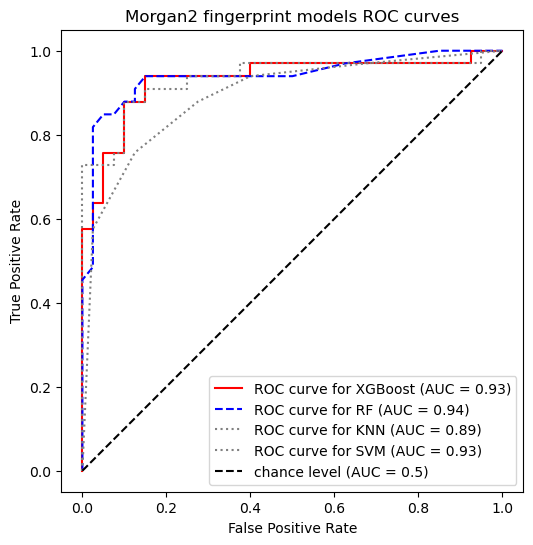

In [20]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=bst_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    color='red',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=rf_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    color='blue',
    linestyle="dashed",
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=knn_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='gray',
    linestyle='dotted',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    color='gray',
    linestyle='dotted',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Morgan2 fingerprint models ROC curves")
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score
knn_y_proba = knn_morgan2.predict_proba(X_Test)[:, 1]
rf_y_proba = rf_morgan2.predict_proba(X_Test)[:, 1]
svm_y_proba = svm_morgan2.predict_proba(X_Test)[:, 1]
bst_y_proba = bst_morgan2.predict_proba(X_Test)[:, 1]

knn_auc_score = roc_auc_score(y_Test, knn_y_proba)
rf_auc_score = roc_auc_score(y_Test, rf_y_proba)
svm_auc_score = roc_auc_score(y_Test, svm_y_proba)
bst_auc_score = roc_auc_score(y_Test, bst_y_proba)
print(knn_auc_score, rf_auc_score, svm_auc_score, bst_auc_score)

0.8928030303030303 0.9401515151515152 0.9333333333333333 0.9310606060606061


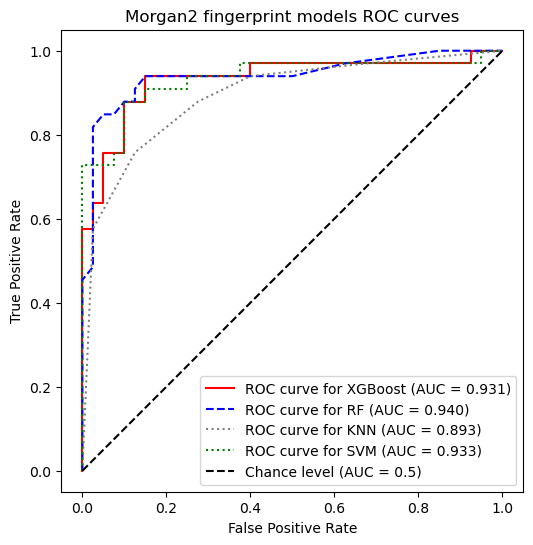

In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Tính toán giá trị AUC cho từng mô hình
bst_y_score = bst_morgan2.predict_proba(X_Test)[:, 1]
bst_auc_score = roc_auc_score(y_Test, bst_y_score)

rf_y_score = rf_morgan2.predict_proba(X_Test)[:, 1] 
rf_auc_score = roc_auc_score(y_Test, rf_y_score)

knn_y_score = knn_morgan2.predict_proba(X_Test)[:, 1]
knn_auc_score = roc_auc_score(y_Test, knn_y_score)

svm_y_score = svm_morgan2.decision_function(X_Test)
svm_auc_score = roc_auc_score(y_Test, svm_y_score)

# Vẽ đường cong ROC cho các mô hình
fig, ax = plt.subplots(figsize=(6, 6))

fpr, tpr, _ = roc_curve(y_Test, bst_y_score)
ax.plot(fpr, tpr, color='red', label=f"ROC curve for XGBoost (AUC = {bst_auc_score:.3f})")

fpr, tpr, _ = roc_curve(y_Test, rf_y_score)
ax.plot(fpr, tpr, color='blue', linestyle='dashed', label=f"ROC curve for RF (AUC = {rf_auc_score:.3f})")

fpr, tpr, _ = roc_curve(y_Test, knn_y_score) 
ax.plot(fpr, tpr, color='gray', linestyle='dotted', label=f"ROC curve for KNN (AUC = {knn_auc_score:.3f})")

fpr, tpr, _ = roc_curve(y_Test, svm_y_score)
ax.plot(fpr, tpr, color='green', linestyle='dotted', label=f"ROC curve for SVM (AUC = {svm_auc_score:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Morgan2 fingerprint models ROC curves")
plt.legend()
plt.show()